In [1]:
# predecir el promedio de diametros de una micrografia de fibras, con transfer learning
import numpy as np

img = np.ones((256,256))



def predict_fiber_mic_mean(img):
    mean = 0
    #to do
    return mean

promedio = predict_fiber_mic_mean(img)

print("promedio:", promedio)

promedio: 0


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from utils.mmdataset import MicsMeansDataset
from torch.utils.data import DataLoader, random_split

In [13]:
model_ft = models.resnet50(pretrained = True)

In [4]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# fine tuning
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

device = ('cuda' if torch.cuda.is_available() else 'cpu')

model_ft = model_ft.to(device)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

In [17]:
from torchsummary import summary

summary(model_ft, (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [18]:
batch_size = 4
val_percent = 0.2

dir_mics = "data_dm_overlapping/test/imgs/"
file_means = "data_dm_overlapping/test/diameter_means.pkl"
img_scale = 1

dataset = MicsMeansDataset(dir_mics, file_means, img_scale, transforms=transforms.Compose([
                                                                    transforms.RandomResizedCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.114, 0.114, 0.114],std=[0.237, 0.237, 0.237])
                                                                ]))

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val

train_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

torch.Size([4, 3, 224, 224])
tensor(7.6101, dtype=torch.float64)


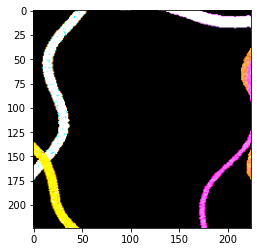

In [19]:
import matplotlib.pyplot as plt

lote = next(iter(train_loader))

print(lote['mics'].size())
print(lote['means'][0])

img = lote['mics'][0].permute(1,2,0)

plt.imshow(img)

In [ ]:
# trainning:

num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model_ft.train()
    train_epoch_loss = 0
    
    for lote in train_loader:
        mics,means = lote['mics'],lote['means']
        mics = mics.to(device, dtype=torch.float32)
        means = means.to(device, dtype=torch.float32)
    
        pred_means = model_ft(mics)
        loss = criterion(pred_means, means)
        train_epoch_loss += loss.item() * mics.size(0)
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    train_losses.append(train_epoch_loss/len(train_data))
    
    model_ft.eval()
    val_epoch_loss = 0
    
    for lote in val_loader:
        mics,means = lote['mics'],lote['means']
        mics = mics.to(device, dtype=torch.float32)
        means = means.to(device, dtype=torch.float32)
    
        with torch.no_grad():
            pred_means = model_ft(mics)
            loss = criterion(pred_means, means)
        
        val_epoch_loss += loss.item() * mics.size(0)
        
    val_losses.append(val_epoch_loss/len(val_data))
    
    print("%5d %11.4f %11.4f" % (epoch, train_epoch_loss/len(train_data), val_epoch_loss/len(val_data)))

    0      3.1720      1.8253
    1      1.8165      7.9634
    2      1.7213      1.7435
    3      1.6598      5.8505
    4      1.7709      1.5312
    5      1.5441     11.4201
    6      1.6447      1.4209
    7      1.5569      2.0221
    8      1.5860      1.4883
    9      1.7337      1.5105
   10      1.6378      1.4856
   11      1.6770      2.1617
   12      1.5489      2.0106
   13      1.5491      1.5529
   14      1.6285      1.5247
   15      1.6821      1.8693
   16      1.5168      1.4582
   17      1.5745      2.0002
   18      1.5510      1.5053
   19      1.5909      1.5064
   20      1.6086      1.4335
   21      1.6471      3.7708
   22      1.5667      2.1009
   23      1.5433      1.8048
   24      1.5245      1.4438
   25      1.5453      1.9273
   26      1.6397      1.5550
   27      1.4982      1.5354
   28      1.6172      1.5253
   29      1.5222      1.5015
   30      1.6115      2.3751
   31      1.4761      1.4812
   32      1.5677      2.4218
   33     